In [764]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Dropout
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

In [765]:
# CSVデータの読み込み
csv_list = ["TimeChart_cyber.csv", "TimeChart_JT.csv", "TimeChart_kose.csv"] # CSVファイルのリスト
data = pd.read_csv('csv/' + csv_list[2], encoding="UTF-8", index_col="日付", parse_dates=True) # CSVファイルの読み込み

In [766]:
# データの整形
data = data.sort_values("日付") # 昔のデータから順番にsort
max_num = data["始値"].max()
data["始値"] /= max_num
X = data["始値"]

In [767]:
# 訓練データとテストデータに分割
train = X[:len(X) * 4 // 5]
test = X[len(X) * 4 // 5:]

# 学習する過去何日分かのデータの作成をする関数の定義
interval = 10
def make_data(data, interval=10):
    input_tensor = [] # 学習データ
    output_tensor = [] # 結果
    open_price = list(data)
    for i in range(len(open_price)):
        if i < interval:
            continue
        output_tensor.append(open_price[i])
        z = []
        for j in range(interval):
            d = i + j -interval
            z.append(open_price[d])
        input_tensor.append(z)
    return (input_tensor, output_tensor)

# 関数の実行
X_train, y_train = make_data(train)
X_test, y_test = make_data(test)

In [768]:
# モデルの構造を定義
model = Sequential()
model.add(Dense(5, input_shape=(interval,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1))
model.add(Activation('linear'))

model.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 5)                 55        
_________________________________________________________________
activation_164 (Activation)  (None, 5)                 0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 6         
_________________________________________________________________
activation_165 (Activation)  (None, 1)                 0         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [769]:
# モデルを構築
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

earlystopping = EarlyStopping(monitor='loss', patience=5)
model.fit(X_train, y_train, batch_size=10, epochs=50, callbacks=[earlystopping])

Epoch 1/50
83/83 [==============================] - 0s 648us/step - loss: 0.0058 - mae: 0.0402
Epoch 2/50
83/83 [==============================] - 0s 689us/step - loss: 0.0036 - mae: 0.0303
Epoch 3/50
83/83 [==============================] - 0s 682us/step - loss: 0.0024 - mae: 0.0272
Epoch 4/50
83/83 [==============================] - 0s 673us/step - loss: 0.0022 - mae: 0.0244
Epoch 5/50
83/83 [==============================] - 0s 641us/step - loss: 0.0019 - mae: 0.0231
Epoch 6/50
83/83 [==============================] - 0s 671us/step - loss: 0.0022 - mae: 0.0255
Epoch 7/50
83/83 [==============================] - 0s 634us/step - loss: 0.0021 - mae: 0.0246
Epoch 8/50
83/83 [==============================] - 0s 639us/step - loss: 0.0021 - mae: 0.0254
Epoch 9/50
83/83 [==============================] - 0s 626us/step - loss: 0.0018 - mae: 0.0224
Epoch 10/50
83/83 [==============================] - 0s 617us/step - loss: 0.0018 - mae: 0.0236
Epoch 11/50
83/83 [==============================

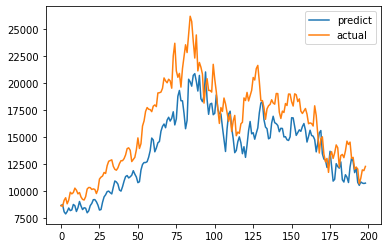

In [770]:
predicted = model.predict(X_test)

predicted_array = np.array(predicted)
predicted_array *= max_num

y_test_array = np.array(y_test)
y_test_array *= max_num

result = pd.DataFrame(predicted_array)
result.columns = ['predict']
result['actual'] = y_test_array
result.plot()
plt.show()

In [771]:
def updown(actual, predict):
    act = np.sign(np.diff(actual))
    pre = np.sign(np.diff(predict[:,0]))
    tmp =  act*pre>0
    return np.sum(tmp)/len(tmp)

print("正解率:", updown(y_test, predicted) * 100, "%")

正解率: 50.0 %


In [772]:
# １〜４週間後の株価を予測
predict_list = []
for i in range(4):
    X_pre = []
    X_pre.append(X[-1:-interval-1:-1])
    X_pre_array = np.asarray(X_pre)
    y_predict_small = model.predict(X_pre_array) # 予測
    result = y_predict_small * max_num
    predict_list.append(result)
    X = list(X)
    X.append(y_predict_small[0][0])
    X = pd.Series(X)
    print("{}週間後: {}".format(i+1, predict_list[i][0][0]))

1週間後: 10906.7158203125
2週間後: 9945.162109375
3週間後: 9111.142578125
4週間後: 8628.9228515625
